<a href="https://colab.research.google.com/github/Harumaru58/Movie-Recommendation-engine/blob/main/Copy_of_Tutorial_Writing_and_Fitting_RL_Models_(Standard).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Writing and Fitting RL Models

In this tutorial, you will create computational models of decision making using model-free and model-based reinforcement learning. Moreover, you will get to use model recovery and model comparison methods to test the performance of your models.

Below, we first recap model free and model based methods and talk about the decision-making paradigm that we are going to use. Then, you will get a chance to try out the task yourself and investigate the behavioral data that we provide. You will then implement two models: a model-free and a model-based one. Finally, you will compare the performance of the two models to see which one is better at explaining the data.

## Model-free vs Model-based Reinforcement Learning

Reinforcement Learning is a model of learning based on reward signals. It can be categorized according to two strategies: model-based and model-free learning. Here, “model” refers to a model of the world or environment and how an agent’s actions affect it.

Model-Free learning is an arguably naive “learn-as-you-go” approach. All that the agent tries to learn is an associative relationship between rewards and choices.

Model-Based Learning mimicks strategic learning. Here, the aim is not just to learn direct reward-choice associations but also to incorporate sensitivity to transition probabilities, using an internal model of the environment.

## The Two-Step Task Paradigm

<p align=center><img src="https://raw.githubusercontent.com/imtezcan/carney-workshop-2024/main/twoStepTask.png" border=2 height="250"><p align=center>Figure 1</p></img></p>


The two-step task (Figure 1) is a standard task used to study how we arbitrate between model-free and model-based learning (Daw et al., 2011). The task is named “two-step” because each trial features two choices. From stage 1 (green), participants probabilistically transition to stage 2 (pink) or stage 2 (blue), depending on their choice. Each of the four possible choices in stage 2 is associated with a distinct reward probability.


In model-free learning, if your choice in stage 2 blue yields a reward, you will increase the value of your stage 1 choice in proportion to that reward by virtue of association. This is the case even if your stage 1 choice only had a slim chance of leading you to the blue variation of stage 2. (Like the left character in stage 1 in Figure 1.)

In model-based learning, the agent tries to learn the transition probabilities between stage 1 and stage 2 before value updates are performed. Knowing these transition probabilities arguably constitutes a model of the environment.

In the next section, we will look at an implementation of the two-step task and analyze data from human participants. We will create our models to explain this data.

### References
Daw, N. D., Gershman, S. J., Seymour, B., Dayan, P., & Dolan, R. J. (2011). Model-Based Influences on Humans’ Choices and Striatal Prediction Errors. Neuron, 69(6), 1204–1215. https://doi.org/10.1016/j.neuron.2011.02.027

# Working with the task and data


First, we need to obtain data that we want to model.

We already provide you with data from 14 participants, which you will be able to load into Colab in the next section. If you want to have a peek at the data first, [here](https://raw.githubusercontent.com/imtezcan/carney-workshop-2024/main/twoStep_experiment_data.csv) is a link.

## Optional: Do the task and collect your own behavioral data

For the purposes of this tutorial, it is enough to use the data that we provide. Alternatively, you can complete the task yourself and download your own behavioral data. However, it is up to you to include your data into the combined data that we provide.

If you decide to do the task, please note that it involves 200 trials and will likely take ~10 minutes to complete.

### Task Instructions

**Scenario:**
During the task you are first presented with two symbols. You can click on one of these symbols to reveal the second step of the task. The second step involves two more symbols that you can pick from. When you make a choice in the second-step, you are either rewarded with a coin, or you will see an empty result, meaning you did not get a reward. **You goal is to get a reward as often as possible.**

**Hint:** The symbols themselves have no inherent meaning. The transition from the first step to the second is stochastic, with a certain probability. The probability of getting a reward is also stochastic.

The picture below shows an example screen.

<img src="https://raw.githubusercontent.com/imtezcan/carney-workshop-2024/main/dawTwoStepTask.png" border=2 height="250"></img>


To try out the task yourself and download your own data, you can open <a href="https://younesstrittmatter.github.io/dawsTwoStep/">this link</a> in your web browser. The experiment will end after you made 200 trials and should take around 10min to complete. After you completed the experiment, your data will be downloaded into your Downloads folder.

**Disclaimer**: The experiment is executed locally in your browser and no data will be stored online, only locally (on your machine). Once you have the data, make sure to store a copy if you want to include it during the modeling task.

### <font color="red">**Question:**
What did you notice about the task? Were you able to figure out a rule? Can you explain what your strategy was for selecting the symbols?</font>

Answer here...

## Load the data

Run the cell below to load the behavioral data remotely and display the first few rows.

In [1]:
import numpy as np
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm.notebook import tqdm

In [2]:
experiment_df = pd.read_csv("https://raw.githubusercontent.com/imtezcan/carney-workshop-2024/main/twoStep_experiment_data.csv")

## Optional - Upload your own data and add it to the combined dataframe

If you want to add your own data, you can use the dialog box below to upload the behavioral data that you downloaded from the two step experiment above. Make sure that the file is called `experiment_data.csv`.

Please skip the two cells below if you do not want to add your own data.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving experiment_data.csv to experiment_data.csv


In [ ]:
additional_df = pd.read_csv('experiment_data.csv')

# Add additional data to the combined one
additional_df['participant_id'] = experiment_df['participant_id'].max() + 1
experiment_df = pd.concat([experiment_df, additional_df], ignore_index=True)

Let's have a quick look at the dataframe that we loaded

In [ ]:
experiment_df.tail()

,participant_id,stepOne_Param,stepOneTwo_Param,stepTwoTwo_Param,rewards_Param,stepOneChoice,stepTwoChoice,reward,rewardProbabilities,isHighProbOne,isHighProbTwo,trial_type,trial_index,time_elapsed,internal_node_id
2795,14,"[1,0]","[0,1]","[3,2]","[false,false,false,false]",1,2,False,"[0.3238119753059419,0.4478040546975933,0.32066...",True,True,dawsTwoStep,195,700479,0.0-195.0
2796,14,"[0,1]","[1,0]","[3,2]","[true,false,true,true]",1,3,True,"[0.2588009687702738,0.4364769616084526,0.32131...",True,True,dawsTwoStep,196,703537,0.0-196.0
2797,14,"[0,1]","[2,3]","[2,3]","[false,false,false,false]",0,2,False,"[0.2766906569822989,0.4362155838947813,0.32809...",False,True,dawsTwoStep,197,706455,0.0-197.0
2798,14,"[1,0]","[1,0]","[1,0]","[false,true,false,true]",0,0,False,"[0.2842094984468859,0.42381734977330465,0.3390...",True,False,dawsTwoStep,198,709544,0.0-198.0
2799,14,"[1,0]","[3,2]","[2,3]","[true,false,false,false]",1,3,False,"[0.2718642201907337,0.43447351913446514,0.3435...",False,True,dawsTwoStep,199,712684,0.0-199.0


## Preprocessing

First we do some preprocessing on the data. Run the cells below, which will make it easier to work with the data.

In [3]:
def preprocess_human_data(data_df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the human data from the experiments
    :param data_df: experiment data as a dataframe
    :return: preprocessed data
    """
    data = data_df.copy()

    # rename column reward_Param to rewardDistribution
    data.rename(columns={'rewards_Param': 'rewardDistribution'}, inplace=True)
    # infer common transition from the action taken in stage 1 and isHighProbOne/Two
    data['common_transition'] = np.where(data['stepOneChoice'] == 0,
                                         data['isHighProbOne'],
                                         data['isHighProbTwo'])

    # infer the state transition to from the action taken in stage 2
    data['state_transition_to'] = (data['stepTwoChoice'] // 2) + 1  # 1 if choice is 0 or 1, 2 if choice is 2 or 3

    # convert the rewardProbabilities from string to an array
    data['rewardProbabilities'] = data['rewardProbabilities'].apply(lambda x: np.array(json.loads(x)))

    # convert the rewardDistribution from string to an array
    data['rewardDistribution'] = data['rewardDistribution'].apply(lambda x: np.array(json.loads(x)))

    # convert stepTwoChoice from range 0-3 to 0-1
    data['stepTwoChoice'] = data['stepTwoChoice'] % 2

    return data

def preprocess_combined_data(combined_df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the combined dataframe containing data from multiple participants
    :param combined_df: combined data as a dataframe
    :return: preprocessed combined data
    """
    preprocessed_data = [
        preprocess_human_data(combined_df[combined_df['participant_id'] == pid])
        for pid in combined_df['participant_id'].unique()
    ]

    return pd.concat(preprocessed_data, ignore_index=True)

In [4]:
preprocessed_df = preprocess_combined_data(experiment_df)
preprocessed_df.head()

,participant_id,stepOne_Param,stepOneTwo_Param,stepTwoTwo_Param,rewardDistribution,stepOneChoice,stepTwoChoice,reward,rewardProbabilities,isHighProbOne,isHighProbTwo,trial_type,trial_index,time_elapsed,internal_node_id,common_transition,state_transition_to
0,1,"[1,0]","[2,3]","[3,2]","[True, False, True, False]",1,1,False,"[0.6238995368157885, 0.3420548510418073, 0.485...",False,True,dawsTwoStep,0,5195,0.0-0.0,True,2
1,1,"[0,1]","[2,3]","[3,2]","[False, False, False, False]",0,1,False,"[0.6588762362282843, 0.3517841002236941, 0.482...",False,True,dawsTwoStep,1,10968,0.0-1.0,False,2
2,1,"[1,0]","[0,1]","[2,3]","[True, False, True, True]",1,1,True,"[0.6042058312627805, 0.4124017672220717, 0.517...",True,True,dawsTwoStep,2,16909,0.0-2.0,True,2
3,1,"[1,0]","[0,1]","[3,2]","[True, True, True, False]",1,1,False,"[0.5392731582276542, 0.4179977610802485, 0.477...",True,True,dawsTwoStep,3,20863,0.0-3.0,True,2
4,1,"[0,1]","[0,1]","[2,3]","[True, True, False, False]",0,1,True,"[0.5689986849945254, 0.4052911463860304, 0.482...",True,True,dawsTwoStep,4,26156,0.0-4.0,True,1


### Plotting the data

Let's plot some characteristics of this data. We will use two main plots:
1. Stay probabilities - the probability of a participant making the same choice as the previous trial, thus sticking to the strategy they may have discovered. We show the plot based on whether the participant was rewarded or not, and whether the transition was common (high probability) or rare (low probability). We plot the final stay probabilities, as well as how they change over trials.
2. Cumulative rewards - how much reward they accumulate over time

Below we define some functions to plot interesting aspects of the data. You don't need to understand them, you can just execute the cells and analyze the plots.

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import os


def calculate_repeated_action(data: pd.DataFrame) -> pd.DataFrame:
    tmp_df = data.copy()
    tmp_df['repeated_stepOneAction'] = tmp_df['stepOneChoice'].shift(1) == tmp_df['stepOneChoice']
    tmp_df['repeated_stepOneAction_next'] = tmp_df['repeated_stepOneAction'].shift(-1)
    return tmp_df.iloc[:-1]

def calculate_stay_probability(data: pd.DataFrame) -> pd.DataFrame:
    tmp_df = calculate_repeated_action(data.copy())
    results = tmp_df.groupby(['reward', 'common_transition'])['repeated_stepOneAction_next'].mean().reset_index()
    results.rename(columns={'repeated_stepOneAction_next': 'Stay Probability', 'reward': 'Rewarded', 'common_transition': 'Common'}, inplace=True)
    results['Condition'] = results.apply(lambda row: f"{'rewarded' if row['Rewarded'] else 'unrewarded'}_{'common' if row['Common'] else 'rare'}", axis=1)
    results['Stay Probability'] = pd.to_numeric(results['Stay Probability'], errors='coerce').fillna(0).round(3)
    return results

def calculate_running_stay_probabilities(data: pd.DataFrame) -> pd.DataFrame:
    task_df = calculate_repeated_action(data.copy())
    conditions = ['common_rewarded', 'common_unrewarded', 'rare_rewarded', 'rare_unrewarded']
    stay_counts = {cond: 0 for cond in conditions}
    total_counts = {cond: 0 for cond in conditions}
    task_df['stay_decision'] = task_df['repeated_stepOneAction_next']
    for i, row in task_df.iterrows():
        condition = f"{'common_' if row['common_transition'] else 'rare_'}{'rewarded' if row['reward'] else 'unrewarded'}"
        if row['stay_decision']:
            stay_counts[condition] += 1
        total_counts[condition] += 1
        for cond in conditions:
            if total_counts[cond] > 0:
                task_df.at[i, f"{cond}_prob"] = stay_counts[cond] / total_counts[cond]
    return task_df.rename(columns={'common_rewarded_prob': 'rewarded_common', 'common_unrewarded_prob': 'unrewarded_common', 'rare_rewarded_prob': 'rewarded_rare', 'rare_unrewarded_prob': 'unrewarded_rare'})

def calculate_average_cumulative_reward_moving_average(data: pd.DataFrame, window_size=10) -> pd.DataFrame:
    tmp_df = data.copy()
    tmp_df['avg_cumulative_reward'] = tmp_df['reward'].rolling(window=window_size, min_periods=1).mean()
    return tmp_df

def plot_combined_single(data, label='', title='', window_size=50):
    sns.set_style("whitegrid")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title, fontsize=16)

    # Plot Stay Probabilities
    stay_prob_df = calculate_stay_probability(data)
    stay_prob_df['Rewarded'] = stay_prob_df['Rewarded'].map({True: 'Rewarded', False: 'Unrewarded'})
    stay_prob_df['Common'] = stay_prob_df['Common'].map({True: 'Common', False: 'Rare'})
    sns.barplot(x='Rewarded', y='Stay Probability', hue='Common', data=stay_prob_df, ax=axes[0], order=['Rewarded', 'Unrewarded'], hue_order=['Common', 'Rare'])
    axes[0].set_title(f'Stay Probabilities - {label}')
    axes[0].set_ylim(0, 1)
    axes[0].legend(loc='upper right')

    # Plot Running Stay Probabilities
    running_stay_df = calculate_running_stay_probabilities(data)
    for cond in ['rewarded_common', 'unrewarded_common', 'rewarded_rare', 'unrewarded_rare']:
        running_stay_df[f'{cond}_ma'] = running_stay_df[f'{cond}'].rolling(window=window_size, min_periods=1).mean()
    running_stay_df.plot(x='trial_index', y=[f'{cond}_ma' for cond in ['rewarded_common', 'unrewarded_common', 'rewarded_rare', 'unrewarded_rare']],
                         ax=axes[1], title=f'Running Stay Probabilities - {label}')

    # Plot Average Cumulative Reward
    avg_cum_reward_df = calculate_average_cumulative_reward_moving_average(data, window_size)
    avg_cum_reward_df.plot(x='trial_index', y='avg_cumulative_reward', ax=axes[2], title=f'Average Cumulative Reward - {label}')
    axes[2].axhline(y=0.5, color='r', linestyle='--', label='Chance Level')
    axes[2].legend(loc='upper right')

    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()


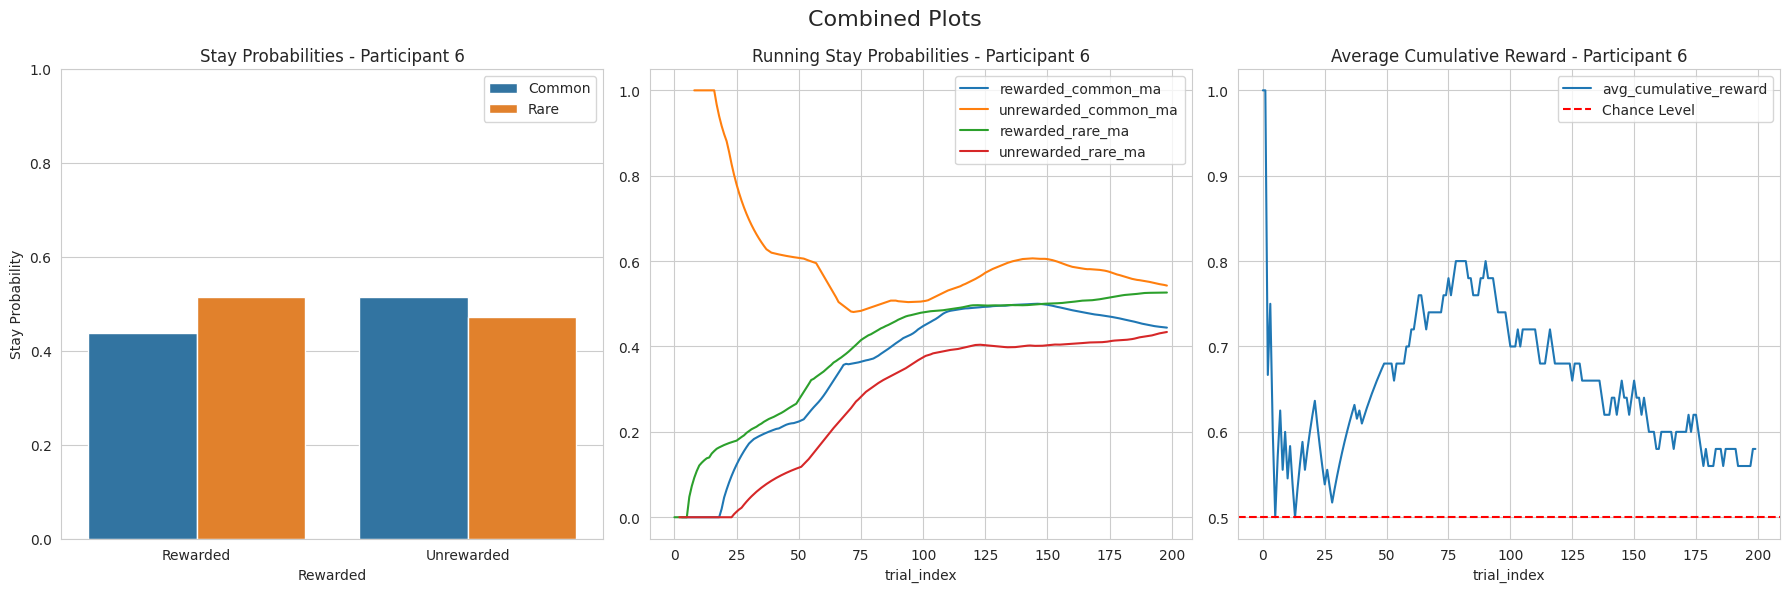

In [11]:
participant_id = 6 # Change this to see other participants
data = preprocessed_df[preprocessed_df['participant_id'] == participant_id]
plot_combined_single(data, label=f'Participant {participant_id}', title='Combined Plots')

Question:

What is your take away from this data? When you model this behavior, which plots are of interest?

## Simulating the environment

When we create reinforcement learning models, we want the agents to observe and act on an environment. To simulate the two-step task, take a look at the code below.

In [12]:
class TwoStepEnv:
    action_space = [0, 1]  # 0: Left 1: Right
    state_space = [0, 1, 2]  # 0: First stage, 1: Second stage left, 2: Second stage right

    def __init__(self):
        self.state = 0
        self.transition_prob = 0.7
        self.reward = 1
        self.terminal = False
        self.info = {}

        # Matrix of transition probabilities. Rows represent actions and columns represent states.
        # 0(action left) -> [0(stay in 0), p(go to 1), 1-p(go to 2)]
        # 1(action right) -> [0(stay in 0), 1-p(go to 1), p(go to 2)]
        # Example: [0, 0.7, 0.3] means that if the agent takes action 0, it will stay in state 0 with probability 0, go to state 1 with probability 0.7 and go to state 2 with probability 0.3.
        self.stage_1_transition_matrix = np.array(
            [[0, self.transition_prob, 1 - self.transition_prob],  # action left
             [0, 1 - self.transition_prob, self.transition_prob]])  # action right

        self.min_reward_prob = 0.25
        self.max_reward_prob = 0.75
        # Reward probabilities. Reward is always 0 for stage 1 (state 0). For stage 2, it is random within a range.
        p_1_0 = np.random.uniform(self.min_reward_prob, self.max_reward_prob)
        p_1_1 = np.random.uniform(self.min_reward_prob, self.max_reward_prob)
        p_2_0 = np.random.uniform(self.min_reward_prob, self.max_reward_prob)
        p_2_1 = np.random.uniform(self.min_reward_prob, self.max_reward_prob)

        self.reward_prob_matrix = np.array(
            [[0, 0],  # first stage (state 0) for both actions
             [p_1_0, p_1_1],  # second stage (state 1) for both actions
             [p_2_0, p_2_1]])  # second stage (state 2) for both actions

        # 1 -> fixed reward prob.
        # 0 -> reward prob. can be changed along the trials
        self.fixed_reward_prob_matrix = np.array([[1, 1],
                                                  [0, 0],
                                                  [0, 0]])
        # Distribution of rewards according to the reward probabilities
        self.reward_distribution = np.zeros_like(self.reward_prob_matrix)
        self.update_reward_distribution()

    def reset(self):
        """
        Reset the environment to the initial state.
        :return: The initial state.
        """

        self.state = 0
        self.terminal = False
        self.info = {}
        return self.state

    def step(self, action):
        """
        Take a step in the environment with the given action.
        :param action: The action to take.
        :return: The new state, the reward, whether the episode is terminated and additional information.
        """
        if self.terminal:
            raise ValueError("Episode has already terminated")
        if action not in self.action_space:
            raise ValueError(f"The action: {action} is not valid, action space: {self.action_space}")

        # If in stage 1 (state 0)
        if self.state == 0:
            reward = self.reward_function(self.state, action)  # Reward will be 0
            # Transition to the next state according to the transition matrix
            self.state = np.random.choice(self.state_space, p=self.stage_1_transition_matrix[action])

            # Update the info
            self.info["common_transition"] = self.is_common_state(self.state, action)
            self.info["state_transition_to"] = self.state
            self.info["stepOneChoice"] = action

        # If in stage 2 (states 1 or 2)
        elif self.state in [1, 2]:
            reward = self.reward_function(self.state, action)
            self.terminal = True
            # Update the info
            self.info["reward"] = reward > 0
            self.info["stepTwoChoice"] = action
            # [2:] -> take the reward probabilities for the second stage only
            self.info["rewardProbabilities"] = self.reward_prob_matrix.flatten()[2:]
            self.info["rewardDistribution"] = self.reward_distribution.flatten()[2:]

        else:
            raise ValueError(f"state:{self.state} is an invalid state, state space: {self.state_space}")

        return self.state, reward, self.terminal, self.info

    def reward_function(self, state, action):
        """
        Probabilistic calculation of the reward for the given state and action. Always 0 for the first stage.
        :param state: The state
        :param action: The action
        :return: The reward
        """
        if action not in self.action_space:
            raise ValueError(f"The action: {action} is not valid, action space: {self.action_space}")
        if state not in self.state_space:
            raise ValueError(f"state:{state} is an invalid state, state space: {self.state_space}")

        self.update_reward_distribution()
        reward = self.reward_distribution[state][action]
        # Scale the reward for a custom reward value equal to self.reward
        # Makes no difference in case self.reward = 1
        reward = int(reward) * self.reward
        return reward

    def is_common_state(self, state, action):
        """
        Check if the given state is a common state for the given action (0.7 probability) or not (0.3 probability)
        :param state: The state that the action leads to
        :param action: The action
        :return: True if the next state is common for the given action, False otherwise.
        """
        if action not in self.action_space:
            raise ValueError(f"The action: {action} is not valid, action space: {self.action_space}")
        if state not in self.state_space:
            raise ValueError(f"state:{state} is an invalid state, state space: {self.state_space}")

        return self.stage_1_transition_matrix[action, state] == np.max(self.stage_1_transition_matrix[action])

    def update_reward_distribution(self):
        """
        Update the reward distribution according to the reward probabilities.
        """
        self.reward_distribution = np.random.uniform(size=self.reward_prob_matrix.shape) < self.reward_prob_matrix
        self.reward_distribution = self.reward_distribution.astype(float)
        return self.reward_distribution

    def set_reward_probabilities(self, reward_prob_matrix):
        """
        Set the reward probabilities to the given matrix
        :param reward_prob_matrix: The reward probability matrix
        :return: The reward probability matrix
        """
        if reward_prob_matrix.shape != self.reward_prob_matrix.shape:
            raise ValueError(
                f"reward_prob_matrix shape: {reward_prob_matrix.shape} is not valid, shape should be {self.reward_prob_matrix.shape}")
        # Clip the reward probabilities to be between min_reward_prob and max_reward_prob
        reward_prob_matrix = np.clip(reward_prob_matrix, self.min_reward_prob,
                                     self.max_reward_prob)

        # Update the reward_prob_matrix
        # if the reward_prob_matrix is fixed -> do not update it, else update it with from the new reward_prob_matrix
        self.reward_prob_matrix = np.where(self.fixed_reward_prob_matrix,
                                           self.reward_prob_matrix, reward_prob_matrix)
        return self.reward_prob_matrix

# Building the Models

Now that we know our data and have an environment to work with, let's begin the actual modeling tasks! You will need to implement two reinforcement learning models - one will be model-free and the other will be model-based.

### Define softmax function

Softmax is a function that take a list of values and converts them into probabilities. The output of the softmax is a list of probabilities, so they sum up to 1. We will use this function in both of our models to output action probabilities.

Here is the formula for softmax:

$$
\text{softmax}(x_i) = \frac{e^{\beta x_i}}{\sum_{j=1}^{N} e^{\beta x_j}}
$$



Fill in the function below to implement the softmax function. You can have a look at the definition of numpy function `np.exp()` to get a clue.

In [17]:
def softmax(vals, beta):
    """
    Softmax function for action selection
    :param vals: The array of action values
    :param beta: Inverse temparature parameter for the softmax policy (higher beta -> more deterministic)
    :return: The probabilities of each action, sums up to 1
    """

    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(beta*vals - np.max(beta*vals))
    return e_x / e_x.sum()

    return result

## Base Agent

We call our reinforcement learning models "agents", since they act on an environment.

Below is a base agent class, which contains variables and functions common to both model-free and model-based agents. Later, you will extend this class to create your model-free and model-based implementations.

First, there is one function that you will need to implement. Please look at the code below, and fill in the `update_q_table` function. Assume that there is already a `calculate_rpe` function, which returns the reward prediction error.



In [18]:
class BaseAgent:
      def __init__(self, env, alpha=0.1, beta=1.0, gamma=0.9):
        """
        Initialize the agent with given parameters
        :param env: Environment that the agent will run on
        :param alpha: Learning rate
        :param beta: Inverse temparature parameter for the softmax policy (higher beta -> more deterministic)
        :param gamma: Discount factor
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        # Initialize the Q-table
        self.q_table = np.zeros((len(env.state_space), len(env.action_space)))

      def get_action_probabilities(self, state):
        """
        Return action probabilities for the given state
        :param state: Current state
        :return: Probability of each action
        """
        q_values = self.q_table[state, :]  # Q values for the given state
        action_probabilities = softmax(q_values, self.beta)
        return action_probabilities

      def policy(self, state):
        """
        Choose an action according to the policy
        :param state: The current state
        :return: Next action
        """
        action_probabilities = self.get_action_probabilities(state)
        action = np.random.choice(self.env.action_space, p=action_probabilities)
        return action

      def update_q_table(self, state, action, reward, next_state, terminal):
        rpe = self.calculate_rpe(state, action, reward, next_state, terminal)
        self.q_table[state, action] += 0

      def calculate_rpe(self, state, action, reward, next_state, terminal):
        # Don't implement this yet
        raise NotImplementedError("To be implemented in sub classes")

## Model-free Q-learning - reward prediction error

Now, we need a function for actually calculating the reward prediction error. This will be used for updating the Q-table. You can implement reward prediction error calculation using the Q-learning algorithm.

As a reminder:

The reward prediction error (RPE) in Q-learning represents the difference between the observed reward plus the discounted future reward and the current estimate of the Q-value.

The equation for the reward prediction error can be written as follows:

$ \text{RPE} = r + \gamma \max_{a'} Q(s', a') - Q(s, a) $

Where:
- $ \text{RPE} $ is the reward prediction error.
- $ r $ is the immediate reward received after taking action $ a $ in state $ s $.
- $ \gamma $ is the discount factor (typically between 0 and 1).
- $ Q(s', a') $ is the estimated value of the optimal future action $ a' $ in the next state $ s' $.
- $ Q(s, a) $ is the current estimated value of taking action $ a $ in state $ s $.

Breaking this down for the code below:
- `reward` corresponds to $r $.
- `self.gamma` corresponds to $ \gamma $.
- `np.max(self.q_table[next_state, :])` corresponds to $ \max_{a'} Q(s', a') $.
- `self.q_table[state, action]` corresponds to $ Q(s, a) $.

In [20]:
class ModelFreeAgent(BaseAgent):
  def calculate_rpe(self, state, action, reward, next_state, terminal):
    if terminal:
      rpe = reward - self.q_table[state, action]
    else:
      rpe = reward + self.gamma * np.max(self.q_table[next_state, :]) - self.q_table[state, action]
    return rpe

## Model-based Q-learning - reward prediction error

Now let's calculate the reward prediction error for the model-based agent. Remember that this will use transition probabilities to judge the values of each state-action pair.
The transition model is already provided inside the class.

As a reminder: In model-based reinforcement learning, the reward prediction error (RPE) accounts for the expected future rewards based on a learned transition model. The RPE calculation is slightly different depending on whether the state is terminal or not.

If the state is terminal, the RPE is calculated as the difference between the reward and the current Q-value:

$ \text{RPE} = r - Q(s, a) $

If the state is not terminal, the RPE calculation involves the expected Q-value based on the transition probabilities to possible next states. The equation for the reward prediction error in this case can be as follows:

$ \text{RPE} = r + \gamma \sum_{s'} P(s'|s, a) \max_{a'} Q(s', a') - Q(s, a) $

Where:
- $ \text{RPE} $ is the reward prediction error.
- $ r $ is the immediate reward received.
- $ \gamma $ is the discount factor (typically between 0 and 1).
- $ P(s'|s, a) $ is the transition probability of moving to state $ s' $ from state $ s $ after taking action $ a $.
- $ \max_{a'} Q(s', a') $ is the estimated value of the optimal future action $ a' $ in the next state $ s' $.
- $ Q(s, a) $ is the current estimated value of taking action $ a $ in state $ s $.

Hint for your code blow:
  - self.transition_model[action]` contains the transition probabilities for a given action $ P(s'|s, a) $.

In [ ]:
class ModelBasedAgent(BaseAgent):
  def __init__(self, env, alpha=0.1, beta=1.0, gamma=0.9):
      super().__init__(env, alpha, beta, gamma)
      self.transition_model = {
          0: [0.7, 0.3],  # Action 0: [prob_state_1, prob_state_2]
          1: [0.3, 0.7]   # Action 1: [prob_state_1, prob_state_2]
      }
  def calculate_rpe(self, state, action, reward, next_state, terminal):
      if terminal:
        rpe = reward - self.q_table[state, action]
      else:
        transition_probs = self.transition_model[action]
        expected_q_value = 0
        for possible_next_state, prob in enumerate(transition_probs, start=1):
            max_q_value = np.max(self.q_table[next_state, :])
            expected_q_value += # YOUR CODE HERE
        rpe = reward + # YOUR CODE HERE
      return rpe

# Simulating Data from the Models

Now that we have our models, let's simulate data from them. We will then inspect this data to make sure that it looks okay, and we will use it for parameter recovery.

Below are two functions necessary to simulate the data. Go ahead and execute the
cells below.

In [ ]:
def random_walk_gaussian(prob, sd, min_prob=0, max_prob=1):
    """
    Simulate a random walk in the reward probabilities using Gaussian noise
    :param prob: initial reward probabilities
    :param sd: standard deviation of the noise
    :param min_prob: minimum range
    :param max_prob: maximum range
    :return: new reward probabilities with added noise
    """
    new_prob = prob + np.random.normal(scale=sd, size=np.shape(prob))
    new_prob = np.clip(new_prob, min_prob, max_prob)
    return new_prob

def simulate(env: TwoStepEnv, agent, trials=200):
    """
    Simulate with given agent
    :param env: environment
    :param agent: given agent
    :param trials: number of trials
    :return: simulated task data as a dataframe
    """
    env.reset()
    task_data = {}
    sd_for_random_walk = 0.025
    time_step = 0
    while time_step < trials:
        # first stage choice
        terminal = False
        while not terminal:
            current_state = env.state
            action = agent.policy(env.state)
            next_state, reward, terminal, info = env.step(action)
            agent.update_q_table(current_state, action, reward, next_state,
                                     terminal)

        info['trial_index'] = int(time_step)
        task_data[time_step] = info
        env.reset()
        # simulate a random walk in the reward probabilities
        new_reward_prob_matrix = random_walk_gaussian(env.reward_prob_matrix,
                                                      sd_for_random_walk)
        env.set_reward_probabilities(new_reward_prob_matrix)
        time_step += 1

    return pd.DataFrame.from_dict(task_data, orient='index')

In [ ]:
env = TwoStepEnv()
agent_mf = ModelFreeAgent(env)
data_mf = simulate(env, agent_mf)

agent_mb = ModelBasedAgent(env)
data_mb = simulate(env, agent_mb)

## Investigate simulated data

Let's see how our initial models perform. The results don't have to be impressive - we didn't fit our models to any data yet. We will do that later, once we validate our models. For now, it is enough that the models can generate data in the correct format, without any errors.

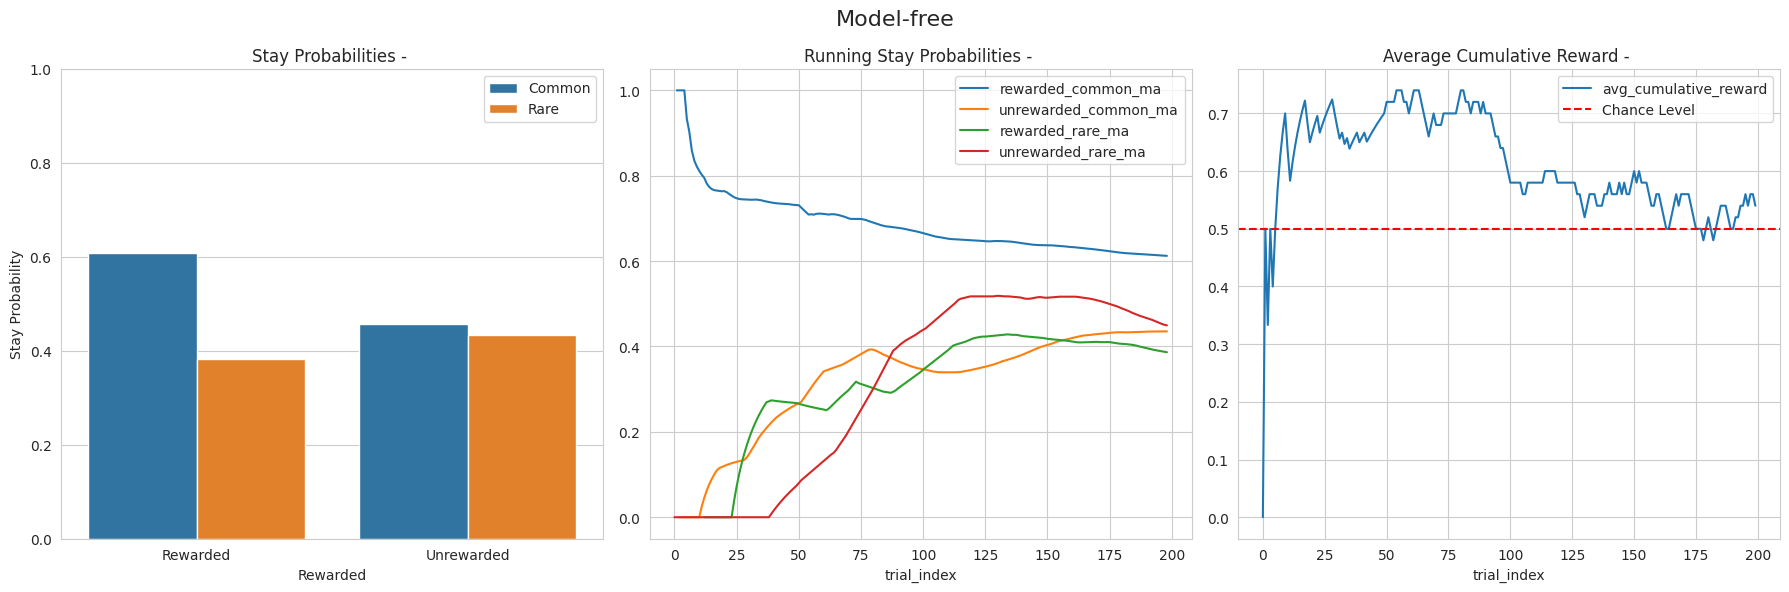

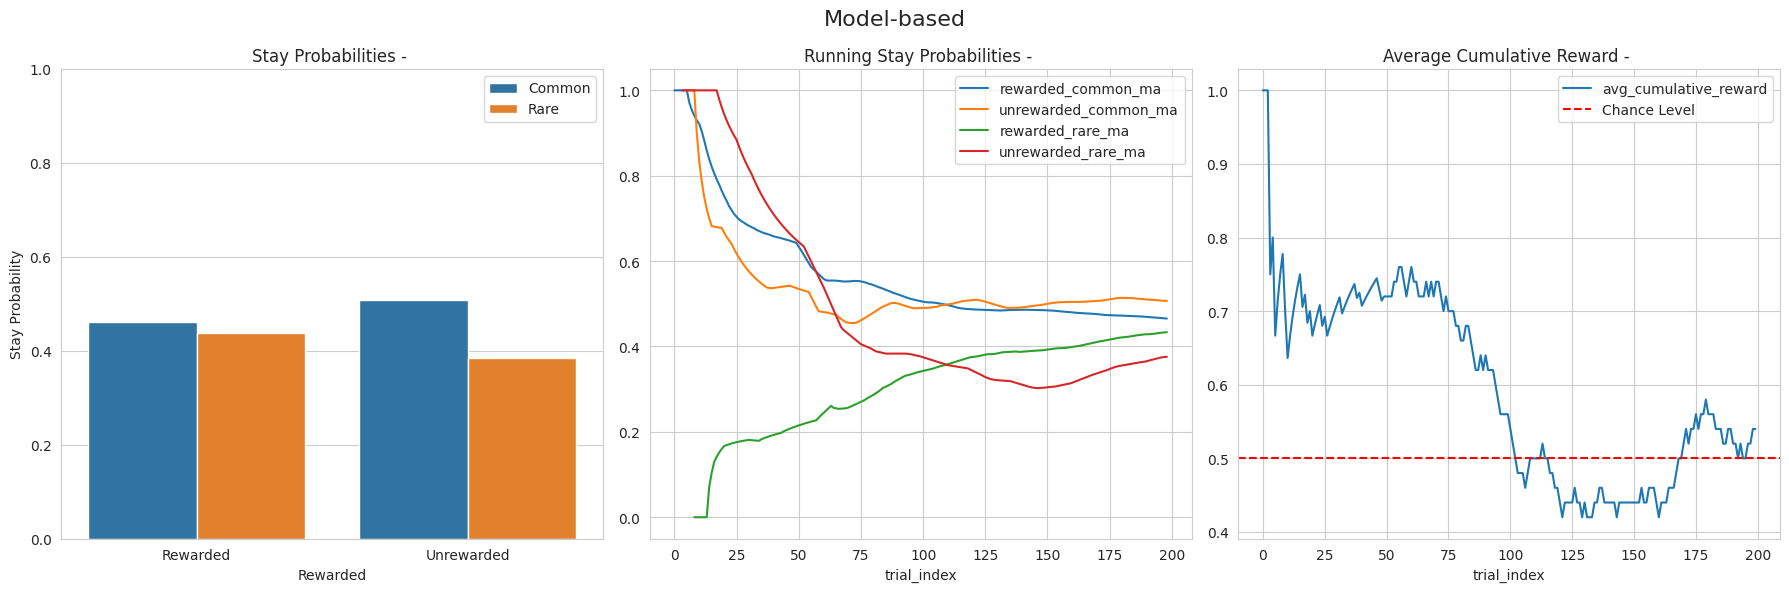

In [ ]:
plot_combined_single(data_mf, title='Model-free')
plot_combined_single(data_mb, title='Model-based')

# Model fitting

We now need functions to fit the models to data. These functions will be used to fit the models to surrogate data, for parameter recovery, as well as to real behavioral data that we inspected in the beginning.

First, we need a log likelihood function. We calculate log likelihood by showing the same first-stage choices to the model, and look at how likely it is to make the same choice as in the data.

In [ ]:
def log_likelihood(agent, data):
    ll_sum = 0
    for idx, trial_data in data.iterrows():
        chosen_action_1 = trial_data['stepOneChoice']
        chosen_action_2 = trial_data['stepTwoChoice']
        stage_1_state = 0
        stage_2_state = trial_data['state_transition_to']
        recieved_reward = int(trial_data['reward'])

        action_probs_stage_1 = agent.get_action_probabilities(stage_1_state)
        chosen_action_1_prob = action_probs_stage_1[chosen_action_1]
        agent.update_q_table(stage_1_state, chosen_action_1, 0, stage_2_state, False)

        action_probs_stage_2 = agent.get_action_probabilities(stage_2_state)
        chosen_action_2_prob = action_probs_stage_2[chosen_action_2]
        agent.update_q_table(stage_2_state, chosen_action_2, recieved_reward, stage_2_state, True)

        ll_sum += np.log(chosen_action_1_prob)
        ll_sum += np.log(chosen_action_2_prob)

    return ll_sum

### Grid search

For searching the parameter space, we need to implement a search algorithm. Since we have only 2 parameters and not much data, we can use grid search. Grid search simply goes through every possible combination of the parameters and calculates log-likelihoods for each combination.

Please implement the function below. It should return two values: a dictionary with the best values of alpha and beta, and a 2D array of log-likelihood values for each combination of alpha and beta.

In [ ]:
def grid_search(env, agent_class, data, param_space):
    best_alpha = 0.0
    best_beta = 0.0
    best_LL = -np.inf
    LL_matrix = np.zeros((len(param_space['alpha']), len(param_space['beta'])))
    for i, alpha in enumerate(tqdm(param_space['alpha'])):
      for j, beta in enumerate(param_space['beta']):
        agent = agent_class(env, alpha=alpha, beta=beta)
        LL = # YOUR CODE HERE
        LL_matrix[i, j] = LL
        if (LL > best_LL):
          best_LL = LL
          best_alpha = alpha
          best_beta = beta
    return {"alpha": best_alpha, "beta": best_beta}, LL_matrix

# Parameter recovery

Now we have our models and the parameters with the best fit. To make sure that we are on the right path, we should always validate our models and the parameter fitting process.

Below, we first simulate data from our models using random values for our parameters. Then, we apply parameter fitting to simulated data. Our goal is to make sure that we can recover the original parameter values.

We will also check that the two parameters (alpha and beta) are not correlated. If they are, it would mean that they do not act as independent variables and it would make it hard to interpret the validity of our models.


In [ ]:
from scipy.stats import uniform


NUM_RUNS = 20
SEED = 0

NUM_ITERATIONS = 256  # Number of iterations for random search
NUM_INITILIZATIONS = 5  # Number of random initializations for minimize search
kwargs_for_fitting_functions = {'num_iterations': NUM_ITERATIONS,
                                'num_initializations': NUM_INITILIZATIONS}

INTERPOLATION_STEPS = 21 # Number of steps for interpolation of the parameter space
# define the parameter space for the simple model free and based
ALPHA_RANGE = (0.01, 0.8)
BETA_RANGE = (-4, 8)

param_space = {'alpha': np.linspace(*ALPHA_RANGE, INTERPOLATION_STEPS),
                'beta': np.linspace(*BETA_RANGE, INTERPOLATION_STEPS)}
param_distributions = {'alpha': uniform(ALPHA_RANGE[0], ALPHA_RANGE[1] - ALPHA_RANGE[0]),
                        'beta': uniform(BETA_RANGE[0], BETA_RANGE[1] - BETA_RANGE[0])}

In [ ]:
def param_recovery(agent_class, parameter_space:dict, num_runs=20):
    true_params = {param : np.random.uniform(np.min(parameter_space[param]), np.max(parameter_space[param]), num_runs)
                for param in parameter_space.keys()}

    # print('true params:',true_params)
    fitted_params = {param : [] for param in parameter_space.keys()}
    best_LLs = []
    env = TwoStepEnv()
    print(env)
    for run in tqdm(range(num_runs), desc='fitting_runs:', total=num_runs, leave=True):
        params = {param : true_params[param][run] for param in parameter_space.keys()}
        # simulate the data
        agent = agent_class(env, **params)
        sim_data = simulate(env, agent)
        # fit the model to the data
        best_params, best_LL = grid_search(env, agent_class, sim_data, param_space)

        # store the fitted parameters and the true parameters
        for param in parameter_space.keys():
            fitted_params[param].append(best_params[param])
        best_LLs.append(best_LL)

    return fitted_params, true_params, best_LLs

In [ ]:
# parameter recovery for the model free agent
fitted_params_mf, true_params_mf, best_ll_mf_list = param_recovery(agent_class=ModelFreeAgent,
                                                        parameter_space=param_space,
                                                        num_runs=NUM_RUNS)

# parameter recovery for the model based agent
fitted_params_mb, true_params_mb, best_ll_mb_list = param_recovery(agent_class=ModelBasedAgent,
                                                        parameter_space=param_space,
                                                        num_runs=NUM_RUNS)

fitting_runs::   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
from scipy.stats import pearsonr


def plot_param_recovery(true_params:dict, fitted_params:dict, title='', max_plots_per_row:int=3, save=False, filename:str='plots/param_recovery.png'):
    n_params = len(true_params)

    rows = (n_params - 1) // max_plots_per_row + 1  # ensure at least one row
    cols = min(n_params, max_plots_per_row)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6*cols, 6*rows))
    fig.suptitle(title)
    axes = axes.flatten()

    for i, param in enumerate(true_params.keys()):
        ax = axes[i]
        true_values = np.array(true_params[param])
        fitted_values = np.array(fitted_params[param])
        sns.scatterplot(x=true_values, y=fitted_values, ax=ax)
        ax.set_title(f'{param}')
        ax.set_xlabel('true')
        ax.set_ylabel('fitted')

        # plot the identity line based on combined min and max of true and fitted values
        combined_values = np.concatenate([true_values, fitted_values])
        min_val, max_val = combined_values.min(), combined_values.max()
        ax.plot([min_val, max_val], [min_val, max_val], ls="--", c=".3")

        # print pearson correlation
        corr_coef_scipy, p_value = pearsonr(true_values, fitted_values)
        print(f'Pearson correlation for {param}: {corr_coef_scipy:.3f}, p_value: {p_value}')

    fig.tight_layout()
    plt.show()

def plot_param_correlation(fitted_params:dict, title='', save=False, filename='plots/recovered_param_correlation.png'):
    # print the correlation uisng scipy pearson
    param_names = list(fitted_params.keys())

    corr = pearsonr(fitted_params[param_names[0]], fitted_params[param_names[1]])
    print(f'corr_1: {corr}')
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.suptitle(title + ' Correlation: ' + f'{corr[0]:.3f}')
    sns.scatterplot(data=fitted_params, x=param_names[0], y=param_names[1], ax=ax)
    ax.set_title(f'{title}_1')
    plt.show()

### Correlation between true and recovered parameters

In an ideal case, the results below should show a strong correlation for both alpha and beta.

Pearson correlation for alpha: 0.761, p_value: 9.866999551655876e-05
Pearson correlation for beta: 0.991, p_value: 2.5572590083765535e-17


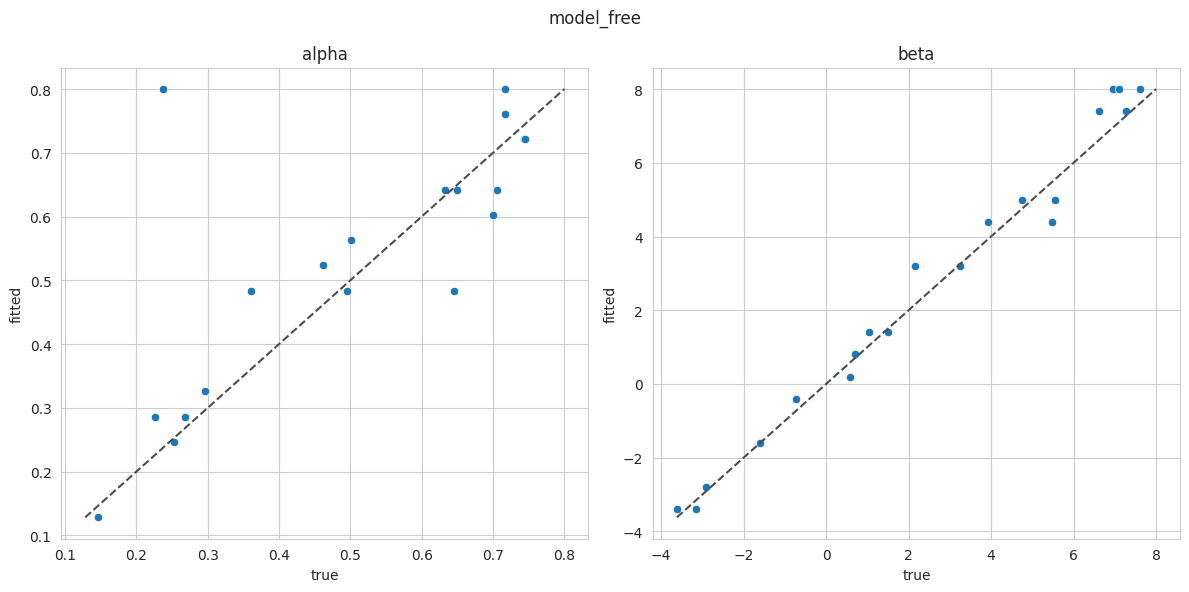

Pearson correlation for alpha: 0.744, p_value: 0.00017069074594798901
Pearson correlation for beta: 0.982, p_value: 1.6537688145219985e-14


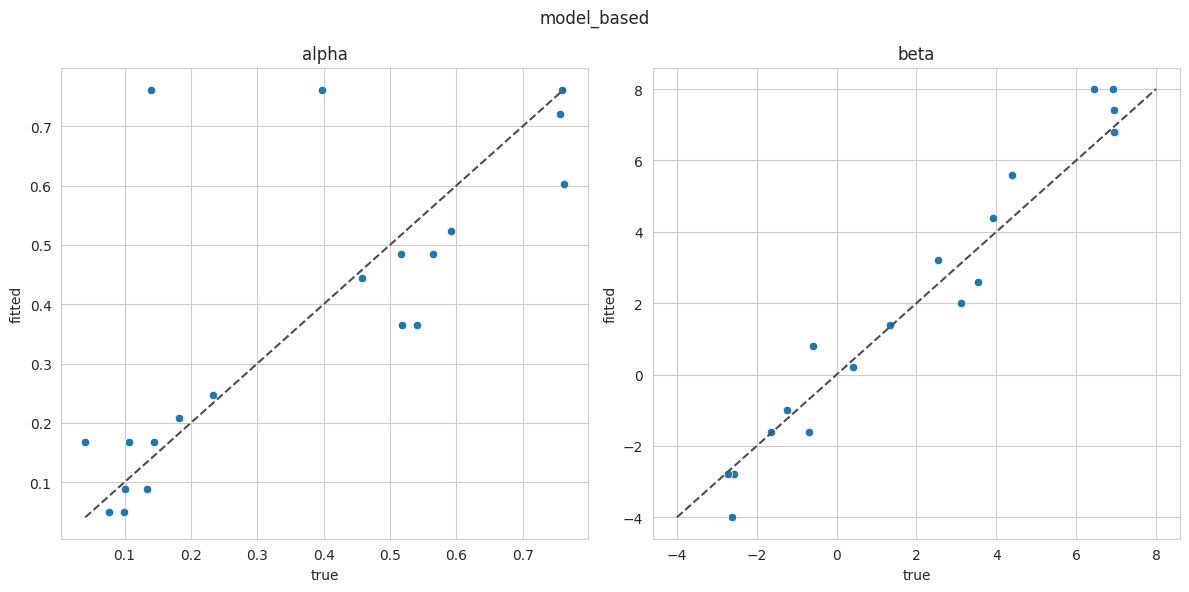

In [ ]:
# plot the results
plot_param_recovery(true_params_mf, fitted_params_mf, 'model_free')
plot_param_recovery(true_params_mb, fitted_params_mb, 'model_based')

### Correlation between model parameters

The results below should ideally not show any correlation. If you see a significant correlation, you should check your model!

corr_1: PearsonRResult(statistic=-0.2541407987421865, pvalue=0.2795869498383114)


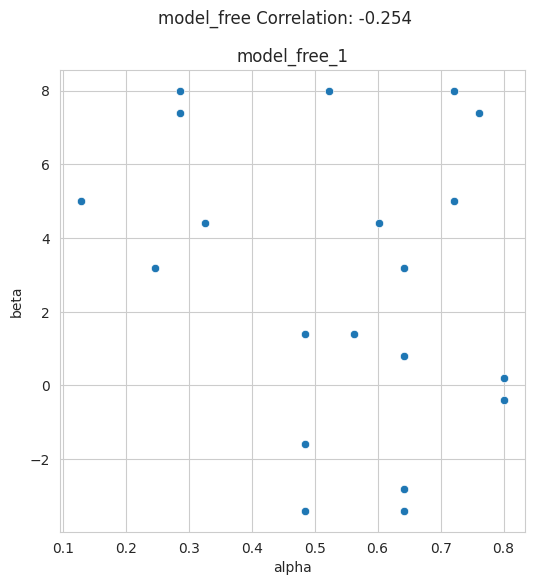

corr_1: PearsonRResult(statistic=-0.22991155706029176, pvalue=0.3294919103905833)


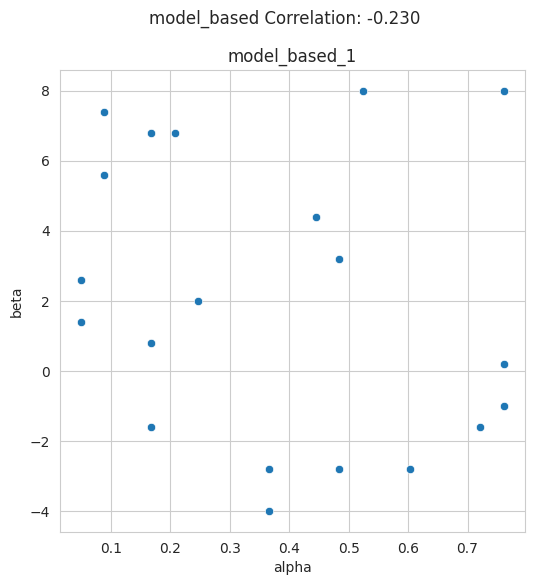

In [ ]:
plot_param_correlation(fitted_params_mf, 'model_free')
plot_param_correlation(fitted_params_mb, 'model_based')

# Fitting models to actual data

Now that we have validated our models, we can finally fit them to real data.
We will work on a single participant. You can change the participant id and see results for each. If you have added your own data, you can pick the last participant id to fit your models to your own data.

In [ ]:
alpha_min = 0.05
alpha_max = 0.8
alpha_resolution = 10
beta_min = 0.1
beta_max = 10
beta_resolution = 30
param_space = {'alpha': np.linspace(alpha_min, alpha_max, alpha_resolution),
               'beta': np.linspace(beta_min, beta_max, beta_resolution)}

In [ ]:
env = TwoStepEnv()
# Fit to data from a single participant
participant_id = 1
data = preprocessed_df[preprocessed_df['participant_id'] == participant_id]

In [ ]:
# Fit model-free agent
best_params_mf, LL_matrix_mf = grid_search(env, ModelFreeAgent, data, param_space)
print(f'MF - Best parameters: {best_params_mf}')

  0%|          | 0/10 [00:00<?, ?it/s]

MF - Best parameters: {'alpha': 0.21666666666666667, 'beta': 4.196551724137931}


In [ ]:
# Fit model-based agent
best_params_mb, LL_matrix_mb = grid_search(env, ModelBasedAgent, data, param_space)
print(f'M - Best parameters: {best_params_mb}')

  0%|          | 0/10 [00:00<?, ?it/s]

M - Best parameters: {'alpha': 0.21666666666666667, 'beta': 4.196551724137931}


### Plot parameter space with results

Below is a function to display the best pair of parameters on a heatmap of possible combinations. The heatmap represents log-likelihood values for each combination of alpha and beta.

In [ ]:
def plot_fit_results(LL_results, parameter_space:dict, title=''):
    (param_1, param_1_space), (param_2, param_2_space) = parameter_space.items()

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle(title)

    x_ticks = np.round(param_2_space, 3)
    y_ticks = np.round(param_1_space, 3)
    visible_ticks_x = [x_ticks[0], x_ticks[len(x_ticks) // 2], x_ticks[-1]]
    visible_ticks_y = [y_ticks[0], y_ticks[len(y_ticks) // 2], y_ticks[-1]]

    im = ax.imshow(LL_results, origin='lower', cmap='inferno')

    ax.set_xlabel(param_2)
    ax.set_xticks([0, len(x_ticks) // 2, len(x_ticks) - 1])
    ax.set_xticklabels(visible_ticks_x)
    ax.set_ylabel(param_1)
    ax.set_yticks([0, len(y_ticks) // 2, len(y_ticks) - 1])
    ax.set_yticklabels(visible_ticks_y)
    ax.set_title('Log Likelihoods')

    fig.colorbar(im, ax=ax, label='Log Likelihood')

    # Annotate the maximum log likelihood on the plot
    max_ll_idx = np.unravel_index(np.argmax(LL_results, axis=None), LL_results.shape)
    max_ll = np.round(LL_results[max_ll_idx], 2)
    max_param_1 = np.round(param_1_space[max_ll_idx[0]], 2)
    max_param_2 = np.round(param_2_space[max_ll_idx[1]], 2)

    ax.annotate(f'Max LL={max_ll}\n{param_1}={max_param_1}, {param_2}={max_param_2}',
            xy=(max_ll_idx[1], max_ll_idx[0]),
            xytext=(max_ll_idx[1]+1, max_ll_idx[0]+1),
            arrowprops=dict(facecolor='darkgreen', shrink=0.005), color='darkgreen', zorder=10, textcoords='offset points')

    fig.tight_layout()
    plt.show()

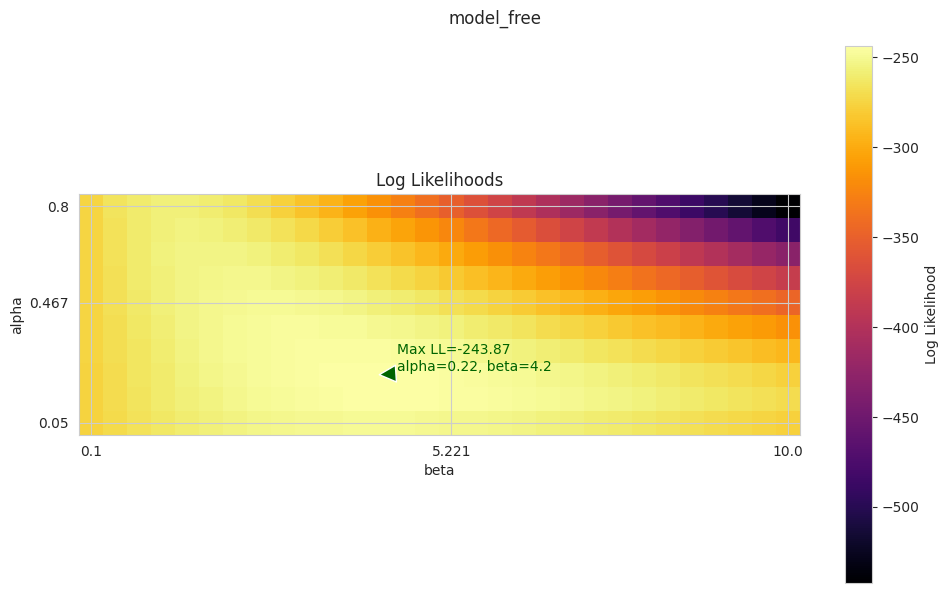

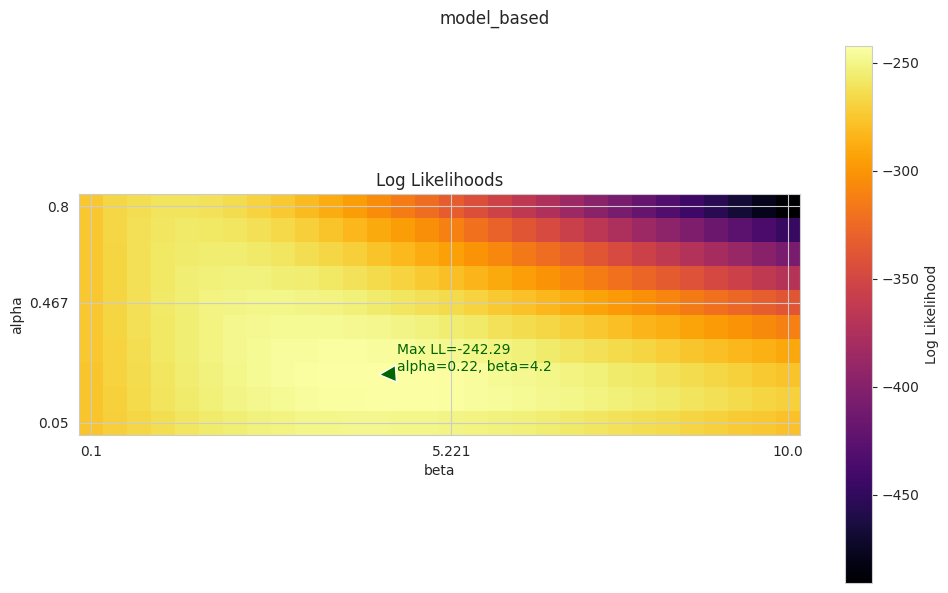

In [ ]:
# plot fit results for simple models
plot_fit_results(LL_matrix_mf, param_space, title='model_free')
plot_fit_results(LL_matrix_mb, param_space, title='model_based')

## Simulate Data with Fitted Models

Now let's simulate data from our models again, after fitting the parameters. This should represent a better fit than the initial values.


In [ ]:
agent_mf_best = ModelFreeAgent(env, **best_params_mf)
data_mf_best = simulate(env, agent_mf_best)

In [ ]:
agent_mb_best = ModelBasedAgent(env, **best_params_mb)
data_mb_best = simulate(env, agent_mb_best)

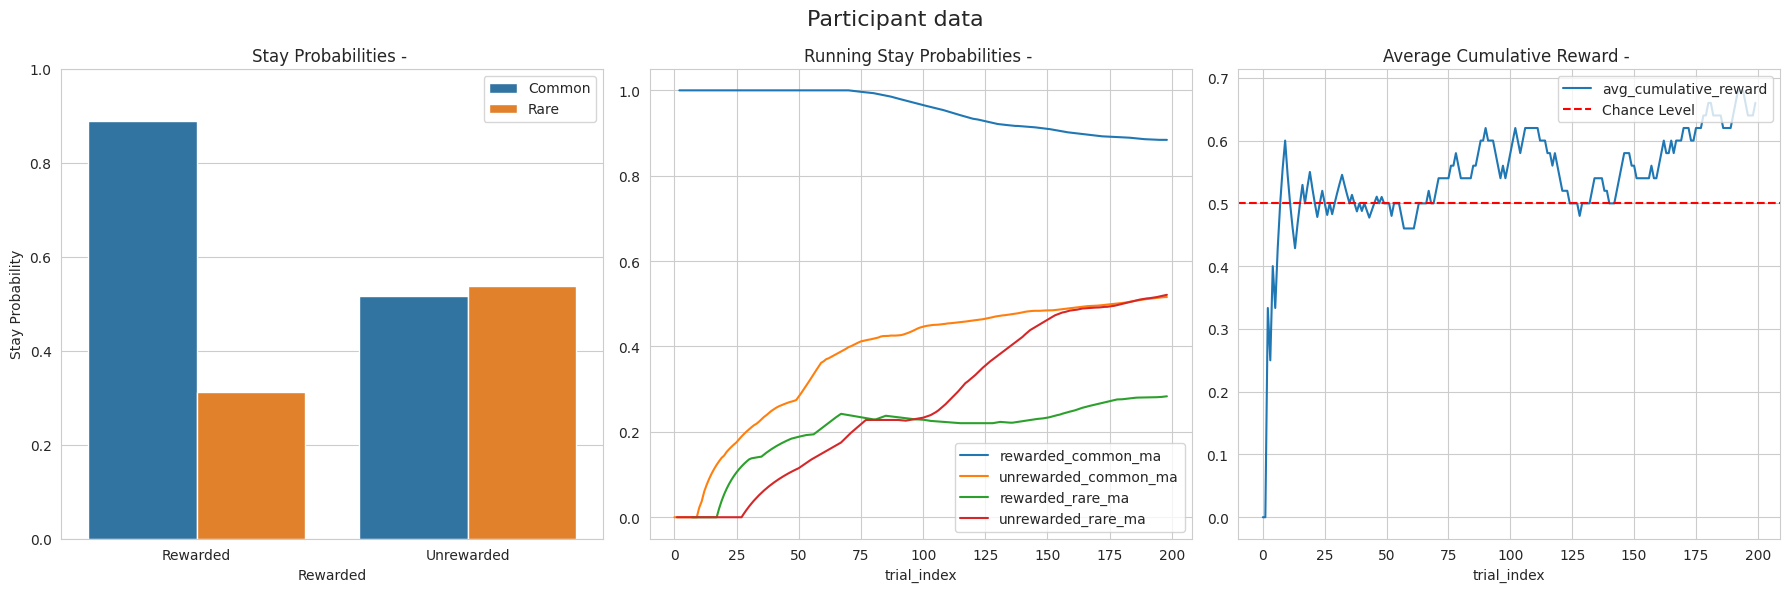

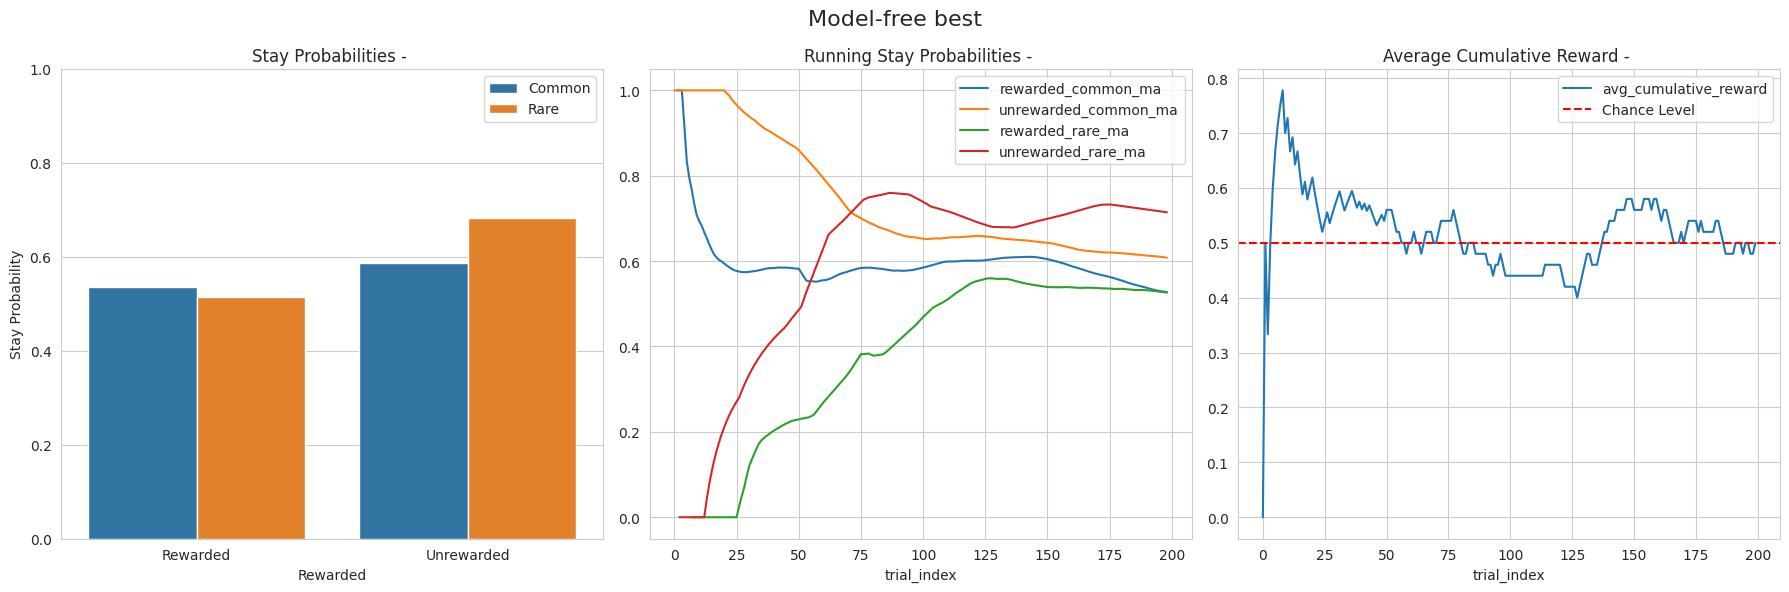

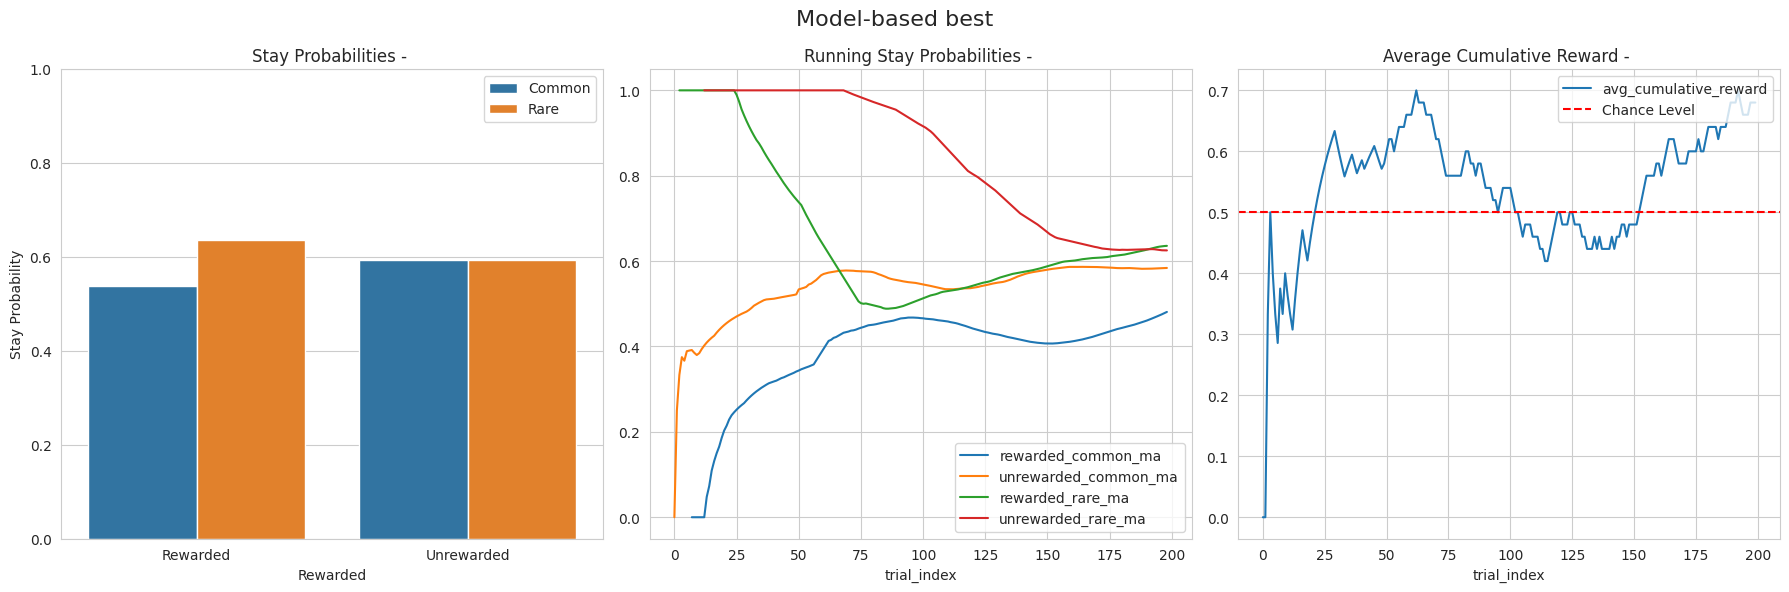

In [ ]:
plot_combined_single(data, title='Participant data')
plot_combined_single(data_mf_best, title='Model-free best')
plot_combined_single(data_mb_best, title='Model-based best')

# Model Comparison

Which model is a better model for the given data? To answer this question, we need to look how well a model can fit to the data. But this is not enough. A model that is complex enough, with too many parameters, may be able to fit to any data. So we need to balance model fit and model complexity.

For this, we use Bayesian Information Criterion (BIC) formula. Below is a function that will return BIC value, given number of parameters of the model, number of data points and log-likelihood values. You will need to implement this function.

In [ ]:
def calculate_bic(num_params, num_data_points, ll):
    """
    Calculates Bayesian Information Criterion to be used in model comparison
    :param num_params: Number of free parameters that the model has
    :param num_data_points: Number of data points the model has been fitted to
    :param ll: Maximum log likelihood estimation for the model given data
    :return:
    """
    return # YOUR CODE HERE

Now let's calculate and display BIC values for model-free and model-based models, along with log-likelihood values.

In [ ]:
num_params = 2  # Same for both models
bic_mf = calculate_bic(2, len(data), LL_matrix_mf.max())
bic_mb = calculate_bic(2, len(data), LL_matrix_mb.max())

results = pd.DataFrame({
    'model': ['model-free', 'model-based'],
    'LL': [LL_matrix_mf.max(), LL_matrix_mb.max()],
    'BIC': [bic_mf, bic_mb]
})

display(results)



,model,LL,BIC
0,model-free,-243.867940,498.332514
1,model-based,-242.289672,495.175978
